In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Carregar os arquivos .h5
rotation_train = h5py.File('Rotation(Distance)\TrainRotation(Distance).h5', 'r')
rotation_test = h5py.File('Rotation(Distance)\TestRotation(Distance).h5', 'r')

translation_train = h5py.File('Translation(Angle))\TrainTranslation(Angle).h5', 'r')
translation_test = h5py.File('Translation(Angle))\TestTranslation(Angle).h5', 'r')

# Acessar os dados de treinamento e teste
x_rotation_train = rotation_train['xtrain']
y_rotation_train = rotation_train['ytrain']
x_rotation_test = rotation_test['xtest']
y_rotation_test = rotation_test['ytest']

x_translation_train = translation_train['xtrain']
y_translation_train = translation_train['ytrain']
x_translation_test = translation_test['xtest']
y_translation_test = translation_test['ytest']

In [3]:
print(x_translation_train.shape)

(35000, 3, 180, 320)


In [4]:
print(min(y_translation_train))

0.5537694072381868


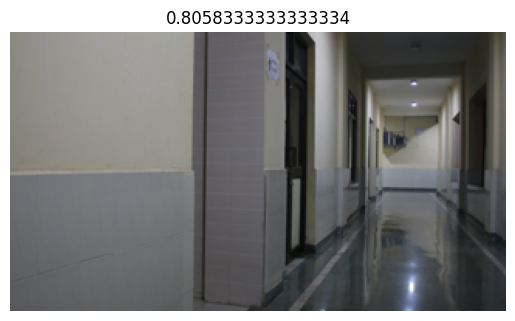

In [5]:
# Acessar a primeira imagem
first_image = x_rotation_train[5]

# Transpor a imagem para ter os canais de cor no último eixo
first_image_transposed = np.transpose(first_image, (1, 2, 0))

# Exibir a imagem
plt.imshow(first_image_transposed)
plt.title(y_rotation_train[5])
# Ocultar os eixos
plt.axis('off')
plt.show()


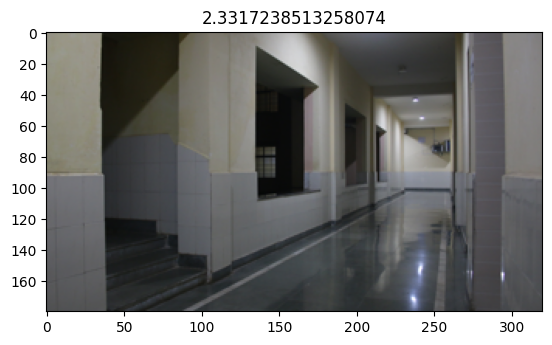

In [6]:
# Acessar a 12a imagem
first_image = x_translation_train[12]

# Transpor a imagem para ter os canais de cor no último eixo
first_image_transposed = np.transpose(first_image, (1, 2, 0))

# Exibir a imagem
plt.imshow(first_image_transposed)
plt.title(y_translation_train[12])
plt.show()


In [7]:
import h5py
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

In [8]:
class CustomDataset(Dataset):
    def __init__(self, h5_file, transform=None):
        self.file = h5py.File(h5_file, 'r')
        if 'Test' in h5_file:
            self.x_data = self.file['xtest'][:1000]
            self.y_data = self.file['ytest'][:1000]
        else:
            self.x_data = self.file['xtrain'][:1000]
            self.y_data = self.file['ytrain'][:1000]
        self.transform = transform
    
    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):
        image = self.x_data[idx]
        label = self.y_data[idx]

        # Transpor para (channels, height, width)
        image = np.transpose(image, (1, 2, 0))

        # Converter o label de contínuo para binário
        label = 1 if label >= 0.3 else 0

        if self.transform:
            image = self.transform(image)
        
        return image, label


# Definir transformações para normalizar as imagens
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Caminho para os arquivos
train_file = 'Rotation(Distance)\TrainRotation(Distance).h5'
test_file = 'Rotation(Distance)\TestRotation(Distance).h5'

# Carregar os datasets
train_dataset = CustomDataset(train_file, transform=transform)
test_dataset = CustomDataset(test_file, transform=transform)

# Dividir os dados de treino em treino e validação
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Criar os DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# Definir uma versão simplificada da VGG
class SimpleVGG(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleVGG, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 22 * 40, 256),  # Ajustar se necessário para o tamanho da entrada
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Verificar se CUDA está disponível e mover o modelo para GPU se possível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleVGG(num_classes=2).to(device)

# Definir loss e optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função de treino com tqdm
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / len(train_loader))
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
        
        # Validação no final de cada época
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    test_bar = tqdm(test_loader, desc="Testing", leave=False)
    
    with torch.no_grad():
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
# Função para avaliar no dataset de teste e medir o tempo de inferência
def evaluate_and_measure_inference_time(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    inference_times = []
    test_bar = tqdm(test_loader, desc="Testing", leave=False)
    
    with torch.no_grad():
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Medir o tempo de inferência
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            # Calcular o tempo de inferência para o lote atual
            inference_time = end_time - start_time
            inference_times.append(inference_time)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_inference_time = sum(inference_times) / len(inference_times)
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
    print(f'Average Inference Time per Batch: {avg_inference_time:.6f} seconds')


Epoch [1/15], Loss: 0.6711, Train Accuracy: 68.38%


Validation Loss: 0.6355, Validation Accuracy: 67.00%


Epoch [2/15], Loss: 0.5506, Train Accuracy: 72.62%


Validation Loss: 0.5056, Validation Accuracy: 73.50%


Epoch [3/15], Loss: 0.3612, Train Accuracy: 84.62%


Validation Loss: 0.3235, Validation Accuracy: 88.50%


Epoch [4/15], Loss: 0.2983, Train Accuracy: 89.12%


Validation Loss: 0.2092, Validation Accuracy: 90.50%


Epoch [5/15], Loss: 0.1723, Train Accuracy: 93.62%


Validation Loss: 0.1644, Validation Accuracy: 96.50%


Epoch [6/15], Loss: 0.1047, Train Accuracy: 96.88%


Validation Loss: 0.0771, Validation Accuracy: 98.00%


Epoch [7/15], Loss: 0.0499, Train Accuracy: 97.62%


Validation Loss: 0.0329, Validation Accuracy: 98.00%


Epoch [8/15], Loss: 0.0147, Train Accuracy: 99.38%


Validation Loss: 0.0946, Validation Accuracy: 97.00%


Epoch [9/15], Loss: 0.0198, Train Accuracy: 99.12%


Validation Loss: 0.0486, Validation Accuracy: 98.00%


Epoch [10/15], Loss: 0.0045, Train Accuracy: 100.00%


Validation Loss: 0.0176, Validation Accuracy: 99.50%


Epoch [11/15], Loss: 0.0016, Train Accuracy: 100.00%


Validation Loss: 0.0718, Validation Accuracy: 98.00%


Epoch [12/15], Loss: 0.1051, Train Accuracy: 98.50%


Validation Loss: 0.1235, Validation Accuracy: 93.50%


Epoch [13/15], Loss: 0.0420, Train Accuracy: 97.75%


Validation Loss: 0.0545, Validation Accuracy: 98.00%


Epoch [14/15], Loss: 0.0182, Train Accuracy: 99.50%


Validation Loss: 0.0580, Validation Accuracy: 97.00%


Epoch [15/15], Loss: 0.0042, Train Accuracy: 99.88%


Validation Loss: 0.0217, Validation Accuracy: 98.50%


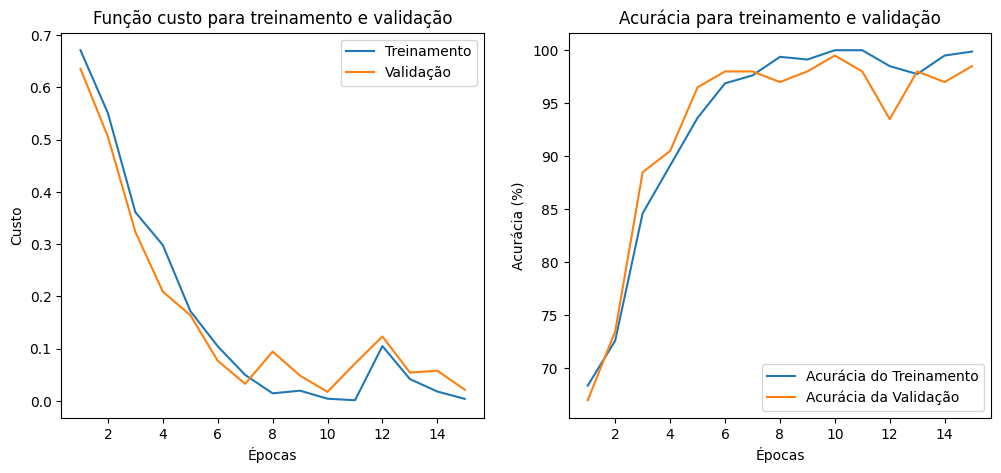

In [10]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Função de treino com gráficos de perda e acurácia e movimentação para CUDA
def train_with_plots(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Cálculo da acurácia no treinamento
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=running_loss / len(train_loader))

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        
        # Validação
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Gerar gráficos de perda e acurácia
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))
    
    # Gráfico de perda
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Treinamento')
    plt.plot(epochs, val_losses, label='Validação')
    plt.title('Função custo para treinamento e validação')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()

    # Gráfico de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Acurácia do Treinamento')
    plt.plot(epochs, val_accuracies, label='Acurácia da Validação')
    plt.title('Acurácia para treinamento e validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia (%)')
    plt.legend()

    plt.show()

# Exemplo de uso
train_with_plots(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)


In [11]:
torch.save(model.state_dict(), 'model_15epochs.pt')
# Avaliar no dataset de teste e medir o tempo de inferência
evaluate_and_measure_inference_time(model, test_loader, criterion)

Test Loss: 0.0499, Accuracy: 98.33%
Average Inference Time per Batch: 0.008229 seconds
